In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import math

In [53]:
class Pam_series:#参数类
    def __init__(self,img_l_Calset_ad,img_r_Calset_ad,camMat_l,camMat_r,dist_l,dist_r,rvecs,tvecs,img_l_ad,img_r_ad,blockSize):
        self.img_l_Calset_ad=img_l_Calset_ad
        self.img_r_Calset_ad=img_r_Calset_ad
        self.camMat_l=camMat_l
        self.camMat_r=camMat_r
        self.dist_l=dist_l
        self.dist_r=dist_r
        self.rvecs=rvecs
        self.tvecs=tvecs
        self.img_l_ad=img_l_ad
        self.img_r_ad=img_r_ad
        self.blockSize=blockSize
    def mod(self):
        if self.camMat_l==None:
            return True
        else:
            return False
Pam=Pam_series(
               img_l_Calset_ad=r"C:\Users\delao\Desktop\Data\left\*.bmp",
               img_r_Calset_ad=r"C:\Users\delao\Desktop\Data\right\*.bmp",
               camMat_l=np.array([[5.347859801204778e+03,0,0],[0,5.350574841506704e+03,0],[9.748426007966679e+02,6.236733312910876e+02,1]]).T,
               camMat_r=np.array([[7.098767860712695e+03,0,0],[0,7.102553579387220e+03,0],[9.097081750340408e+02,6.244755014399113e+02,1]]).T,
               dist_l=np.array([-0.111163865731777,2.753625470972829,0,0,0]),
               dist_r=np.array([-0.027357011977946,-1.985581188272772,0,0,0]),
               rvecs=np.array([[0.999416738570253,0.032328680731352,0.011001775664386],
                              [-0.032352835976846,0.999474459232070,0.002024684424001],
                              [-0.010930538406429,-0.002379442147193,0.999937428835032]]).T,
               tvecs=np.array([-99.717260083345440,-1.853295331713976,9.290465463503027]).T,#MATLAB标定数据
               img_l_ad=r"C:\Users\delao\Desktop\Data\left\left0009.bmp",
               img_r_ad=r"C:\Users\delao\Desktop\Data\right\right0009.bmp",
               blockSize=7
               )

In [54]:
def Calibrate(sampt,adset,limnum=30):#单目标定
    img_adset=glob.glob(adset)
    sterpt_arr=[]
    cornpt_arr=[]
    fal_read=[]
    count=0
    sterpt=np.zeros((sampt[0]*sampt[1],3),np.float32)
    x,y=np.mgrid[0:sampt[0],0:sampt[1]]
    sterpt[:,:2]=cv2.merge((np.transpose(x),np.transpose(y))).reshape(-1,2)#生成世界坐标
    for img_ad in img_adset:
        img=cv2.imread(img_ad,0)#依次读入图片
        ret,cornpt=cv2.findChessboardCorners(img,sampt)#寻找棋盘点
        if ret==True:
            cornpt=cv2.cornerSubPix(img,cornpt,(11,11),(-1,-1),(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30,0.001))#亚像素角点检测
            sterpt_arr.append(sterpt)
            cornpt_arr.append(cornpt)
            count+=1
            if count>=limnum:
                break
        else:
            fal_read.append(img_ad)#记录未找到棋盘点的图片
    img_size=img.shape[::-1]
    ret,camMat,dist,rvecs,tvecs=cv2.calibrateCamera(sterpt_arr,cornpt_arr,img_size,None,None)#相机标定，计算参数
    return sterpt_arr,cornpt_arr,camMat,dist,img_size   

In [55]:
def Rectify(img_l,img_r,camMat_l_n,dist_l_n,camMat_r_n,dist_r_n,rvecs_st,tvecs_st):#立体校正和畸变矫正
    rec_rvecs_l,rec_rvecs_r,rec_tvecs_l,rec_tvecs_r,stertrfrMat,validPixROI1,validPixROI2=\
    cv2.stereoRectify(camMat_l_n,dist_l_n,camMat_r_n,dist_r_n,img_l.shape[:2][::-1],rvecs_st,tvecs_st,1,(0,0))
    l_map1,l_map2=cv2.initUndistortRectifyMap(camMat_l_n,dist_l_n,rec_rvecs_l,rec_tvecs_l,img_l.shape[:2][::-1],cv2.CV_16SC2)
    r_map1,r_map2=cv2.initUndistortRectifyMap(camMat_r_n,dist_r_n,rec_rvecs_r,rec_tvecs_r,img_r.shape[:2][::-1],cv2.CV_16SC2)
    #分别计算图像校正变换矩阵
    res_l=cv2.remap(img_l,l_map1,l_map2,cv2.INTER_LINEAR)
    res_r=cv2.remap(img_r,r_map1,r_map2,cv2.INTER_LINEAR)#得出校正后图像
    return res_l,res_r,stertrfrMat

In [56]:
if Pam.mod==True:   
    sterpt_arr,cornpt_arr_l,camMat_l,dist_l,img_size=Calibrate((7,6),Pam.img_l_Calset_ad)
    sterpt_arr,cornpt_arr_r,camMat_r,dist_r,img_size=Calibrate((7,6),Pam.img_r_Calset_ad,limnum=len(cornpt_arr_l))
    if len(cornpt_arr_r)<len(cornpt_arr_l):
        sterpt_arr,cornpt_arr_l,camMat_l,dist_l,img_size=Calibrate((7,6),Pam.img_l_Calset_ad,limnum=len(cornpt_arr_r))
    ret,camMat_l_n,dist_l_n,camMat_r_n,dist_r_n,rvecs_st,tvecs_st,E,F=\
    cv2.stereoCalibrate(sterpt_arr,cornpt_arr_l,cornpt_arr_r,camMat_l,dist_l,camMat_r,dist_r,img_size)
else:
    camMat_l_n=Pam.camMat_l
    camMat_r_n=Pam.camMat_r
    dist_l_n=Pam.dist_l
    dist_r_n=Pam.dist_r
    rvecs_st=Pam.rvecs
    tvecs_st=Pam.tvecs

In [57]:
def SGBM(img_l,img_r,blockSize=9):#视差计算
    if len(img_l.shape)==2:
        img_dim=1
    else:
        img_dim=3#读入图像通道数
    SGBM_pam_l={#设定SGBM参数
            #预处理参数
            'preFilterCap':1,#映射滤波器大小
            #代价计算参数
            'minDisparity':0,#最小视差，决定左图像素点在右图匹配起点
            'numDisparities':64,#视差搜索范围，16的整数倍
            'blockSize':blockSize,#代价计算窗口大小，根据实际状况设置，值越大视差图越平滑
            #动态规划参数
            'P1':8*img_dim*blockSize*blockSize,#相邻像素点视差增减1时的惩罚系数
            'P2':32*img_dim*blockSize*blockSize,#相邻像素点视差变化大于1时的惩罚系数
            #优化处理参数
            'uniquenessRatio':10,#唯一性检测参数(区分误匹配，值越大检测区分越强)
            'disp12MaxDiff':-1,#一致性检测最大允许误差
            'speckleWindowSize':100,#视差联通区域最小允许像素点个数
            'speckleRange':100,#视差联通最大允许视差变化值
            'mode':cv2.STEREO_SGBM_MODE_HH#不同模式下速度与效果不同
            }
    SGBM_ster_l=cv2.StereoSGBM_create(**SGBM_pam_l)
    disp_l=SGBM_ster_l.compute(img_l,img_r)#计算视差
    # disp_l_n=disp_l.astype(np.float32)/16.#转换为实际视差    
    return disp_l


In [58]:
def ColorDisp(disp):#转彩色
    disp_n=cv2.normalize(disp,None,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)
    disp_color=cv2.applyColorMap(disp_n,2)
    return disp_color

In [59]:
def mouse_click(event,x,y,flags,param):
    if event==cv2.EVENT_LBUTTONDOWN:
        threeD=param
        print('\n像素坐标x = %d,y = %d'%(x, y))
        print("世界坐标是:",threeD[y][x][0],threeD[y][x][1],threeD[y][x][2],"mm")
        distance=math.sqrt(threeD[y][x][0]**2+threeD[y][x][1]**2+threeD[y][x][2]**2)
        print("距离是:",distance,"mm")

In [60]:
img_l=cv2.imread(Pam.img_l_ad,0)
img_r=cv2.imread(Pam.img_r_ad,0)
rvecs_st=Pam.rvecs
tvecs_st=Pam.tvecs
img_l_re,img_r_re,stertrfrMat=Rectify(img_l,img_r,camMat_l_n,dist_l_n,camMat_r_n,dist_r_n,rvecs_st,tvecs_st)
disp_l=SGBM(img_l_re,img_r_re,Pam.blockSize)
dep_l=ColorDisp(disp_l)
dep_l_m=cv2.cvtColor(dep_l,cv2.COLOR_BGR2RGB)
disp_l_n=cv2.normalize(disp_l,disp_l,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)

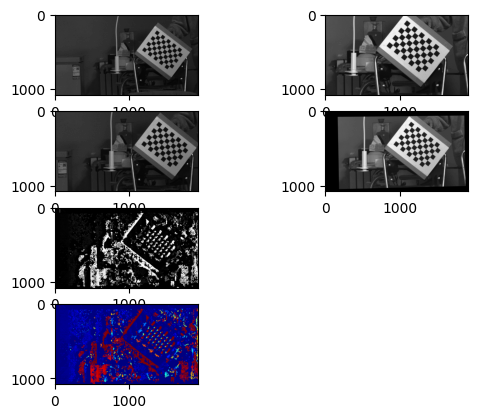

In [61]:
plt.subplot(421),plt.imshow(img_l,cmap='gray')
plt.subplot(422),plt.imshow(img_r,cmap='gray')
plt.subplot(423),plt.imshow(img_l_re,cmap='gray')
plt.subplot(424),plt.imshow(img_r_re,cmap='gray')
plt.subplot(425),plt.imshow(disp_l_n,cmap='gray')
plt.subplot(427),plt.imshow(dep_l_m)
plt.show()

In [62]:
cv2.imshow('depth',dep_l)
threeD=cv2.reprojectImageTo3D(disp_l,stertrfrMat)
threeD=threeD*16
cv2.setMouseCallback("depth",mouse_click,threeD)
cv2.waitKey()


像素坐标x = 767,y = 372
世界坐标是: -1732.6477 -544.1169 13323.187 mm
距离是: 13446.390980105009 mm

像素坐标x = 547,y = 576
世界坐标是: -1660.3 -81.087395 10039.303 mm
距离是: 10175.989917946537 mm


-1